In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pulse_potentials as pp
import schrodinger as sch
from constants import Constants
from pulse_potentials import Potential


In [2]:
script_dir = pathlib.Path().resolve()
data_dir = script_dir / 'output' / 'pot'

consts = Constants('Si/SiGe')
gate_names = ['C1', 'C2', 'B1', 'B2', 'B3', 'B4', 'B5', 'P1', 'P2', 'P3', 'P4']
ppot = Potential(data_dir, gate_names, consts)

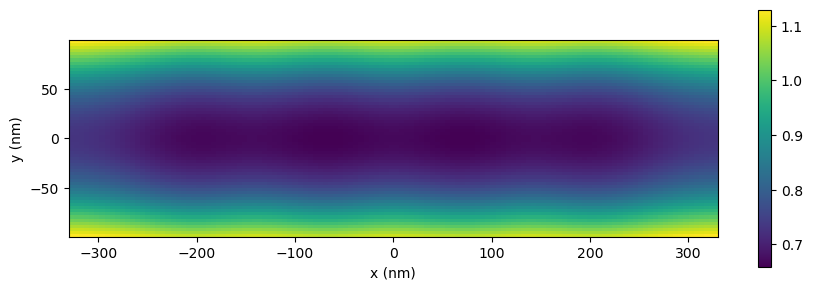

In [3]:
voltages = {'C1': -1, 'C2': -1}
ppot.plot_potential(voltages)

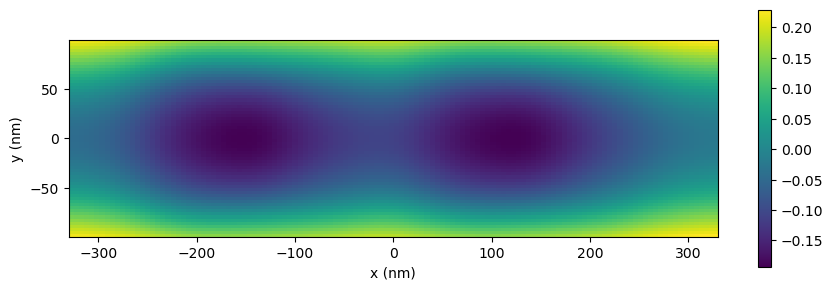

In [4]:
T = 1 / 1e9  # period of the pulse (s)
pulse_length = 1.5 * T

A = 0.2  # amplitude of the pulse (V)
B = 0.73  # offset of the pulse (V)
dB = 0.07  # offset of the pulse for different layers (V)
C1 = -0.0  # lateral gate voltage (V)
C2 = -0.0  # lateral gate voltage (V)

def V1(t): return A * np.cos(-2*np.pi*t/T + 0  *np.pi) + B
def V2(t): return A * np.cos(-2*np.pi*t/T + 0.5*np.pi) + B + dB
def V3(t): return A * np.cos(-2*np.pi*t/T + 1  *np.pi) + B
def V4(t): return A * np.cos(-2*np.pi*t/T + 1.5*np.pi) + B + dB

V_list = [V1, V2, V3, V4]

voltages = {'C1': C1,
            'C2': C2,
            'B1': V4,
            'P1': V1,
            'B2': V2,
            'P2': V3,
            'B3': V4,
            'P3': V1,
            'B4': V2,
            'P4': V3,
            'B5': V4}

ppot.make_pulse(pulse_length=pulse_length, pulse_shape=voltages, pulse_name='pulse1')
# ppot.plot_pulse([g for g in gate_names if g not in ['C1', 'C2']])
ppot.plot_potential(0.2*T)

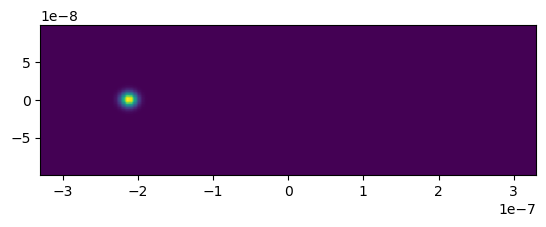

In [5]:
# Define where the electron should be placed initially
x0 = -210e-9
y0 = 0
x_width = 100e-9
y_width = 100e-9

xrange = (x0 - 0.5*x_width, x0 + 0.5*x_width)
yrange = (y0 - 0.5*y_width, y0 + 0.5*y_width)


eigval, wavefunction = sch.get_instantaneous_eigenfunction(ppot, 0, xrange=xrange, yrange=yrange)
plt.imshow(np.abs(wavefunction) ** 2, extent=[ppot.x.min(), ppot.x.max(), ppot.y.min(), ppot.y.max()])
# plt.imshow(np.imag(wavefunction), extent=[ppot.x.min(), ppot.x.max(), ppot.y.min(), ppot.y.max()])

In [6]:
import cProfile
import pstats

# Define where the electron should be placed initially
xi = -210e-9
yi = 0
xf = 210e-9
yf = 0
x_width = 100e-9
y_width = 100e-9

xrange = ((xi - 0.5*x_width, xi + 0.5*x_width),
          (xf - 0.5*x_width, xf + 0.5*x_width))

yrange = ((yi - 0.5*y_width, yi + 0.5*y_width),
          (yf - 0.5*y_width, yf + 0.5*y_width))

dt = 1e-15  # time step (s)
num_evals = 50

# あなたの関数を含むファイル（TE_solver）をインポート
# from your_module import TE_solver

# 関数をプロファイルする
def profile_TE_solver():
    dt = 5e-16
    # cProfile を使って TE_solver をプロファイル
    profiler = cProfile.Profile()
    profiler.enable()
    
    # TE_solver を実行
    sch.TE_solver(ppot, xrange, yrange, dt=dt, num_evals=num_evals)
    
    # プロファイル結果を取得
    profiler.disable()
    stats = pstats.Stats(profiler)
    stats.sort_stats('tottime')
    stats.print_stats()

# プロファイルを実行
# profile_TE_solver()


dt = 1e-15


100%|██████████| 50/50 [17:47<00:00, 21.35s/it]

Elapsed time: 1081.91 s


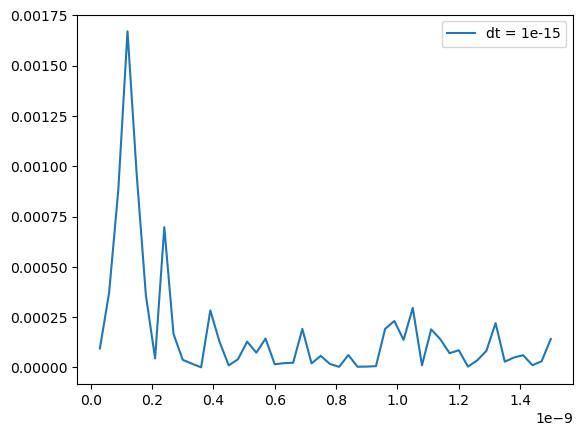

In [7]:
from time import time
dt_list = [1e-12, 1e-13, 1e-14, 1e-15, 5e-16]
dt_list = [1e-15]
pulse_resolution = 1e-14

num_evals = 50

for dt in dt_list:
    print(f'dt = {dt:.0e}')
    pulse_reso = round(pulse_resolution / dt)
    t0 = time()
    F, result = sch.TE_solver(ppot, xrange, yrange, dt=dt, pulse_reso=pulse_reso, num_evals=num_evals)
    print(f'Elapsed time: {time() - t0:.2f} s')
    plt.plot(F[0], F[1], label=f'dt = {dt:.0e}')
plt.legend()
plt.show()

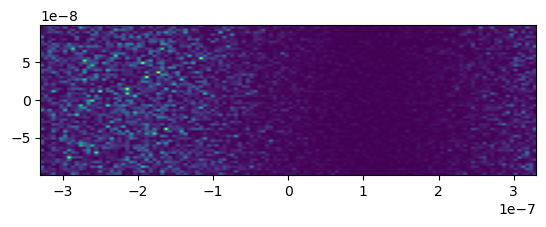

In [16]:
plt.imshow(np.abs(result[10])**2, extent=[ppot.x.min(), ppot.x.max(), ppot.y.min(), ppot.y.max()])

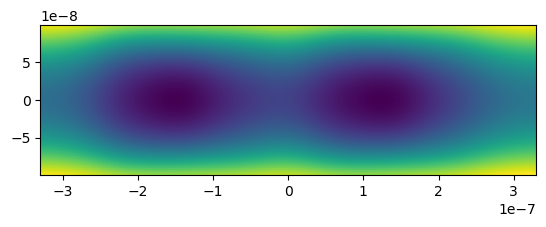

In [13]:
plt.imshow(ppot.get_potential(1.5*T/50), extent=[ppot.x.min(), ppot.x.max(), ppot.y.min(), ppot.y.max()])

In [14]:
dx = ppot.x[1] - ppot.x[0]
dy = ppot.y[1] - ppot.y[0]

sch.inner_prod(wavefunction, wavefunction, dx, dy)

ValueError: operands could not be broadcast together with shapes (128,) (64,127) 